In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
class BasisRegressor(nn.Module):
  def __init__(self, basis, alpha):
    super().__init__()
    self.basis = basis
    self.degree = len(basis)
    self.alpha = alpha
    self.input_layer = nn.Linear(self.degree, 1)

  def feature_map(self, x):
    x.unsqueeze(1)
    output = torch.cat([f(x) for f in self.basis], 1)
    return output

  def constraint(self):
    return torch.norm(self.input_layer.weight)**2

  def forward(self, x):
    output = self.feature_map(x)
    output = self.input_layer(output)
    return output

  def loss(self, X, y):
    output = torch.mean((self.forward(X) - y).pow(2))
    # output += self.alpha*self.constraint()
    return output

  def train(self, X, y, epochs = 500, learning_rate = 1e-2):
    optimizer = torch.optim.SGD(self.parameters(), lr = learning_rate)
    self.losses = []
    for epoch in range(epochs):
      error = self.loss(X,y)
      self.losses.append(error.item())
      self.zero_grad()
      error.backward(retain_graph = True)
      optimizer.step()

In [3]:
def monomial_basis(degree):
  return [lambda x, i=i: x ** i for i in range(degree + 1)]

In [4]:
degree = 7
alpha = 0
basis = monomial_basis(degree)
size = 100
batch_size = 50
epochs = 2000
lr = .01

In [5]:
x_data = torch.linspace(0, 2, size).resize(size, 1)
y_data = np.cos(2*x_data) + .1 * torch.randn(size,1)
#y_data = np.log(x_data + 1) + .01 * torch.randn(size,1)
# monomial basis can be unstable for values outside of [-1,1] so let's normalize the data
m, M = x_data.min(), x_data.max()
a = 2/(M - m)
b = 1 - a * M
X_normalized = a*x_data + b
indices = random.choices(range(size), k = batch_size)
X_train = X_normalized[indices]
y_train = y_data[indices]


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [6]:
model = BasisRegressor(basis, alpha)
model.train(X_train,y_train, epochs, lr)

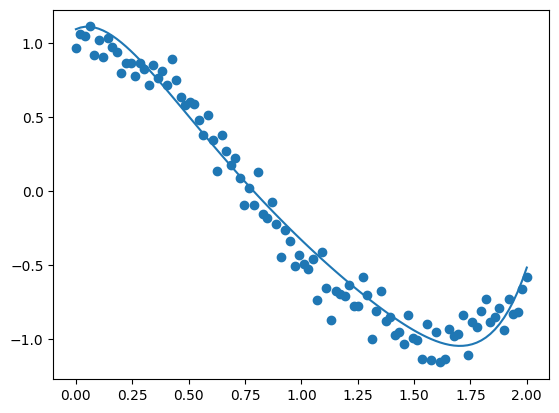

In [7]:
plt.scatter(x_data, y_data, label = "real")
plt.plot(x_data, model.forward(X_normalized).detach().numpy(), label = "approximate")
plt.show()

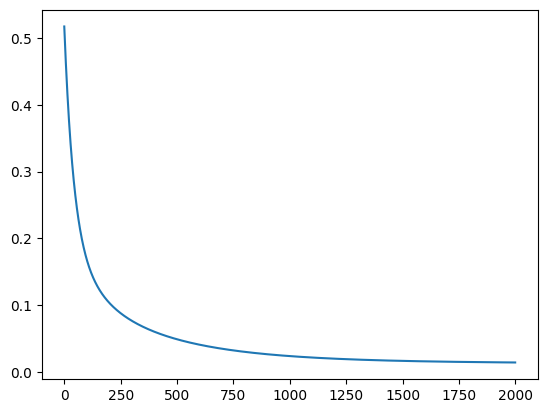

In [8]:
plt.plot(range(epochs), model.losses)

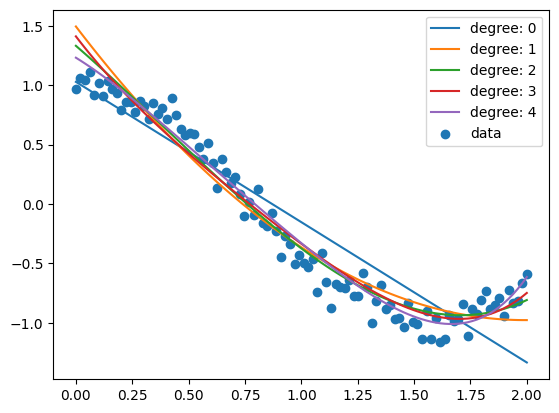

In [9]:
for i in range(5):
  model = BasisRegressor(monomial_basis(i + 1), .1)
  model.train(X_train,y_train, epochs, lr)
  plt.plot(x_data, model.forward(X_normalized).detach().numpy(), label = "degree: " + str(i))

plt.scatter(x_data,y_data, label = "data")
plt.legend()
plt.show()

In [10]:
model.input_layer.weight

Parameter containing:
tensor([[-0.1169, -1.5456,  0.3066,  0.3969,  0.3315,  0.2250]],
       requires_grad=True)

In [11]:
def fourier_basis(degree):
  sines = [lambda x, i=i: np.sin((2*i + 1)*np.pi*x) for i in range(degree//2 + 1)]
  cosines = [lambda x, i=i: np.cos(2*i*np.pi*x) for i in range(degree//2 + 1)]
  return sines + cosines

In [12]:
degree = 10
alpha = .001
basis = fourier_basis(degree)
size = 100
batch_size = 75
epochs = 5000
lr = .001

In [13]:
x_data = torch.linspace(.001, 1, size).resize(size, 1)
#y_data = np.sin(10*x_data)/x_data + .1 * torch.randn(size,1)
y_data = (x_data - .5 * torch.ones(size, 1)).pow(2) + .01 * torch.randn(size,1)
indices = random.choices(range(size), k = batch_size)
X_train = x_data[indices]
y_train = y_data[indices]

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [14]:
model = BasisRegressor(basis, alpha)
model.train(X_train,y_train, epochs, lr)

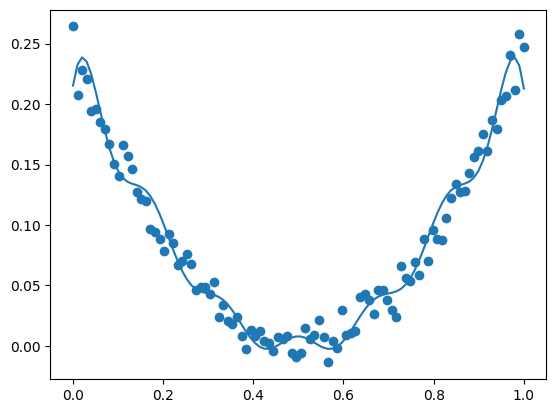

In [15]:
plt.scatter(x_data, y_data, label = "real")
plt.plot(x_data, model.forward(x_data).detach().numpy(), label = "approximate")
plt.show()

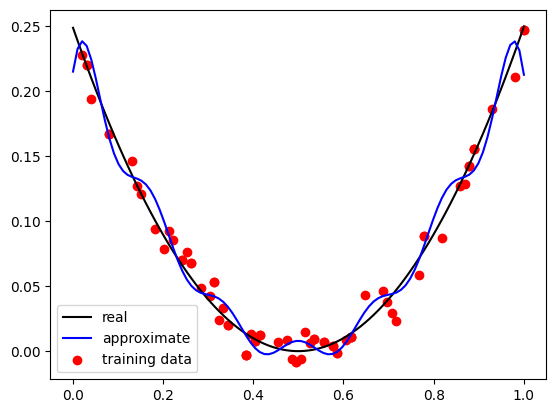

In [16]:
plt.plot(x_data, (x_data - .5 * torch.ones(size, 1)).pow(2), c = "black",label = "real")
plt.plot(x_data, model.forward(x_data).detach().numpy(), c = "blue", label = "approximate")
plt.scatter(X_train, y_train, c = "red", label = "training data")
plt.legend()
plt.show()

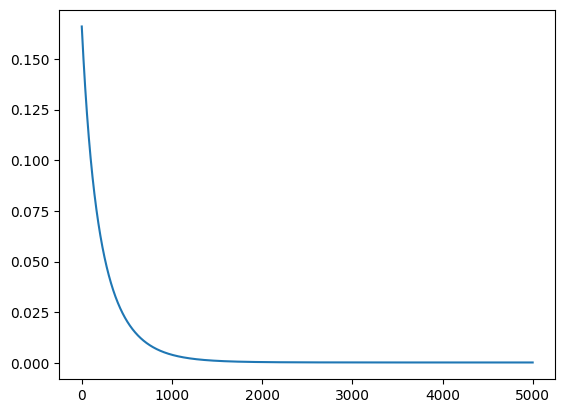

In [17]:
plt.plot(range(epochs), model.losses)